# PEtab Control

In this notebook, we demonstrate a two-step procedure to control a process, where the two steps are:
1. understand the process by estimating unknown model parameters
2. control the process by estimating unknown control parameters

The original PEtab problem fully specifies the problem in step 1. The output of step 1 + the PEtab Control files fully specify step 2.

In this notebook, variables suffixed with `0` are associated with step 1. 

If you already know your model parameters, simply replace step 1 with the calibrated PEtab problem, with the `unscaled_parameters0` value.

NB: in this case, we convert the control problem to an SBML model with events. Any PEtab-compatible calibration tool that supports SBML models with events can be used, for example COPASI. We use pyPESTO here. The tools do not need to be developed further to support PEtab Control.

## Step 1

### Import original PEtab problem
In this case, our original problem is in the PEtab Timecourse format. A standard PEtab problem is also fine.

In [1]:
import petab
import petab_timecourse

petab_problem0 = petab_timecourse.Problem.from_yaml(
    'input/optimize_then_control/petab/estimate/petab_problem.yaml',
)

petab_problem0.model = petab.models.sbml_model.SbmlModel(
    petab_timecourse.sbml.add_timecourse_as_events(
        petab_problem=petab_problem0,
        timecourse_id="timecourse1",
    )
)
petab_problem0.extensions_config = None

### Calibration

In the next cells, the original problem is calibrated to fit the previously-measured data, such that model parameters can be estimated.

In [2]:
import pypesto.petab

pypesto_importer0 = pypesto.petab.PetabImporter(petab_problem0)
pypesto_problem0 = pypesto_importer0.create_problem()

Visualization table not available. Skipping.


None
model0
/home/dilan/Documents/future_annex/optimal_control/packages/petab_control/doc/examples/amici_models/model0


In [3]:
import pypesto.optimize

pypesto_engine = pypesto.engine.MultiProcessEngine(7)

pypesto_result0 = pypesto.optimize.minimize(pypesto_problem0, filename=None, n_starts=20, engine=pypesto_engine)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 60.03it/s]


The fit looks OK, and it appears the global optimum was found, as the waterfall plot shows high convergence to the same best (minimal) objective value, and the parameters from all of these starts are the same. Hence, we can be somewhat confident that we have estimated the parameters of the mathematical model well.

(<Figure size 1500x1000 with 1 Axes>, <Axes: >)

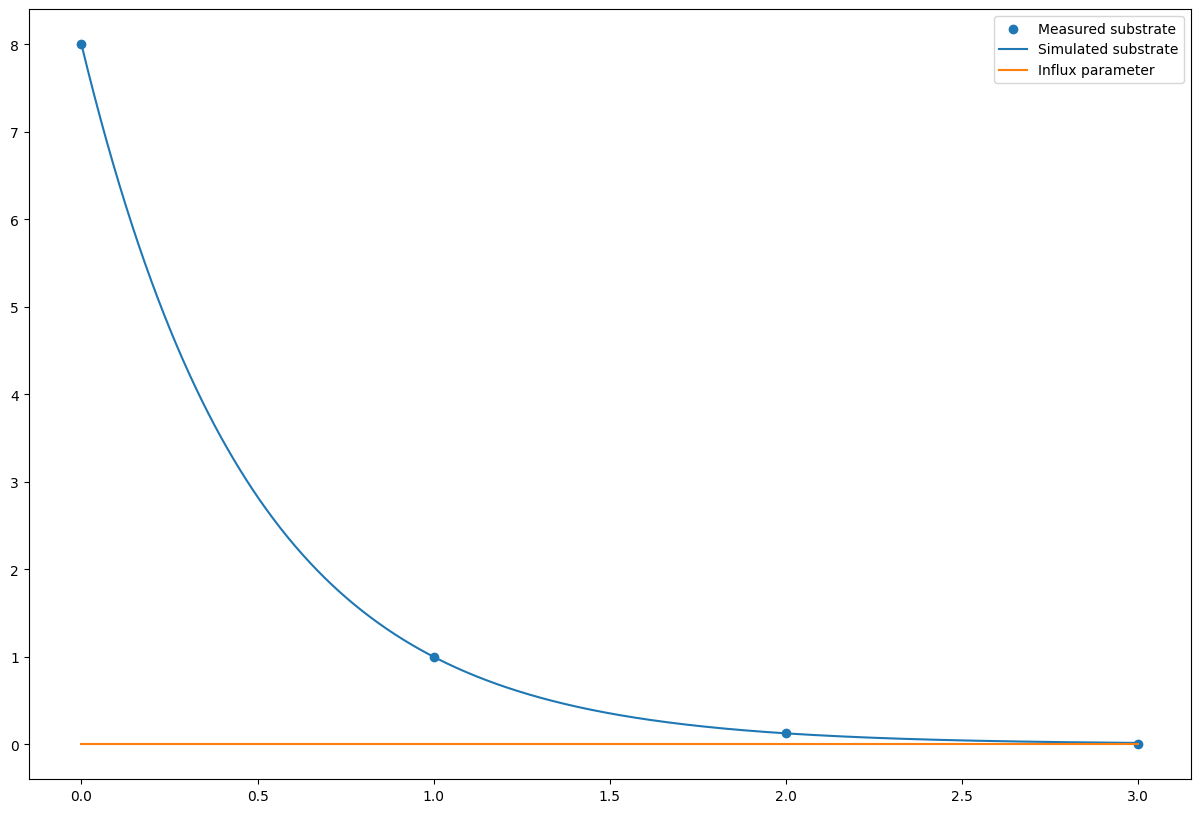

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_solution(
    pypesto_problem,
    pypesto_result,
    petab_problem,
    controlled,
):
    objective = pypesto_problem.objective.set_custom_timepoints(timepoints_global=np.linspace(0, petab_problem.measurement_df.time.max(), 1001))
    simulation = objective(
        pypesto_result.optimize_result.list[0].x[pypesto_problem.x_free_indices],
        return_dict=True,
    )['rdatas'][0]
    fig, ax = plt.subplots(figsize=(15,10))
    substrate = simulation.x[:, objective.amici_model.getStateIds().index('substrate')]

    if 'influx' in objective.amici_model.getStateIds():
        influx = simulation.x[:, objective.amici_model.getStateIds().index('influx')]
    else:
        influx = objective.amici_model.getFixedParameters()[objective.amici_model.getFixedParameterIds().index('influx')]
        influx = [influx] * simulation.t
    
    ax.scatter(
        petab_problem.measurement_df.time,
        petab_problem.measurement_df.measurement,
        label=('Measured substrate' if not controlled else 'Desired substrate'),
    )

    ax.plot(simulation.t, substrate, label='Simulated substrate')
    
    ax.plot(simulation.t, influx, label='Influx parameter')

    ax.legend()

    return fig, ax

plot_solution(pypesto_problem=pypesto_problem0, pypesto_result=pypesto_result0, petab_problem=petab_problem0, controlled=False)

<Axes: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=-2.676e+00)'>

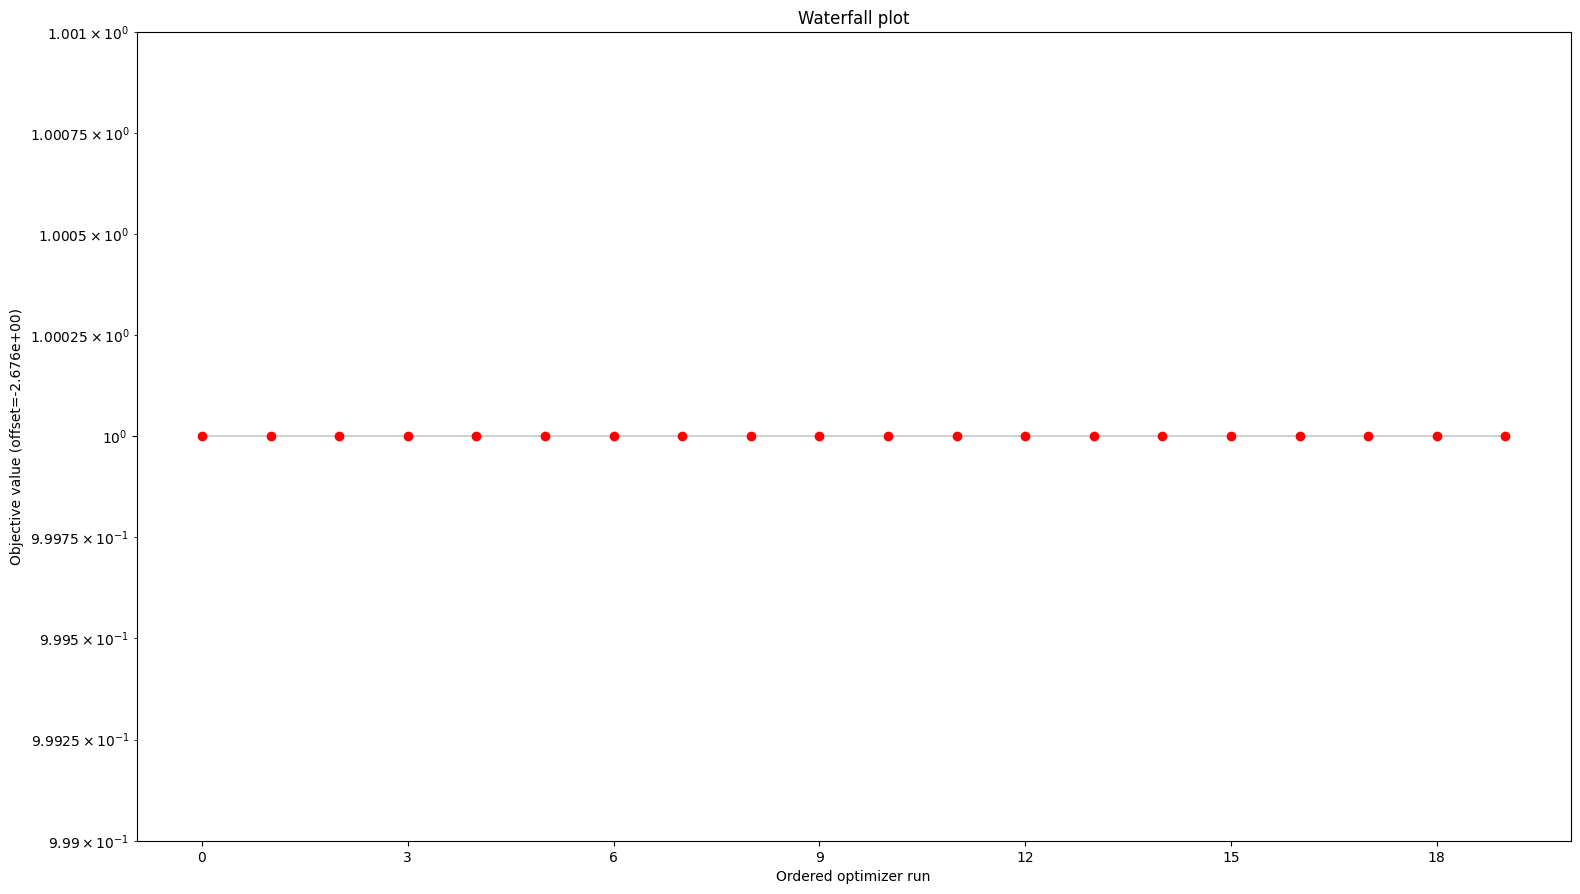

In [5]:
pypesto.visualize.waterfall(pypesto_result0)

<Axes: title={'center': 'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

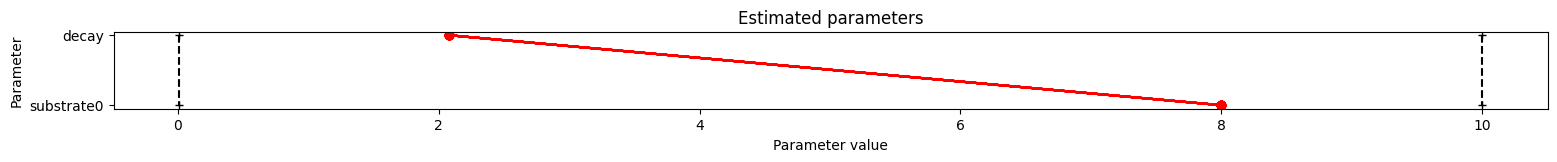

In [6]:
pypesto.visualize.parameters(pypesto_result0)

We save these optimal model parameters. PEtab Control fixes the model parameters to their optima when estimating the control parameters.

In [7]:
unscaled_parameters0 = petab_problem0.unscale_parameters(dict(zip(
    pypesto_problem0.x_names,
    pypesto_result0.optimize_result.list[0].x
)))

## Step 2
### Setup controlled PEtab problem

We setup the controlled PEtab problem by applying the control problem to the original problem.

In [8]:
import petab
import petab_control
import petab_timecourse

petab_control_problem = petab_control.Problem.from_yaml(
    yaml_path='input/optimize_then_control/petab/control/petab_control_problem.yaml',
)

petab_problem = petab_control.get_control_events_petab_problem(
    petab_control_problem=petab_control_problem,
    petab_problem=petab_problem0,
    unscaled_parameters0=unscaled_parameters0,
    timecourse_id='timecourse1',
)

The PEtab Control control parameters table defines how the controlled model parameters are estimated. The structure is the same as a standard PEtab parameters table.

In [9]:
petab_control_problem.control_parameter_df

,parameterScale,lowerBound,upperBound,nominalValue,estimate
parameterId,,,,,
influx,log10,0.0001,10000,0.1,1


The PEtab Control controls table then defines individual controls. It links them to the control parameters table, and further specifies the time when the control is applied, and the value it takes. This allows a controlled model parameter to take different values at different time points.

In [10]:
petab_control_problem.control_df

,control_id,parameterId,time,value,datasetId
0,influx_00,influx,0.0,0.1,control
1,influx_20,influx,20.0,estimate,control
2,influx_40,influx,40.0,estimate,control
2,influx_40,influx,50.0,estimate,control
2,influx_40,influx,70.0,estimate,control
3,influx_60,influx,60.0,5.0,control
4,influx_80,influx,80.0,estimate,control


The PEtab Control objective measurements table defines the objectives of the optimal control problem. Here, you can specify the values that you want the model to produce at different timepoints. The structure is the same as a standard PEtab measurements table.

In [11]:
petab_control_problem.objective_measurement_df

,observableId,time,measurement,datasetId,simulationConditionId
0,observable_substrate,28,0.5,control,timecourse1
1,observable_substrate,38,0.5,control,timecourse1
2,observable_substrate,48,6.5,control,timecourse1
3,observable_substrate,58,6.5,control,timecourse1
4,observable_substrate,68,0.5,control,timecourse1
5,observable_substrate,78,6.5,control,timecourse1
6,observable_substrate,88,0.5,control,timecourse1
7,observable_substrate,98,0.5,control,timecourse1
8,observable_substrate,108,0.5,control,timecourse1


The PEtab Control objective observables table defines how the model components map onto the objectives of the optimal control problem. The structure is the same as a standard PEtab observables table.

In [12]:
petab_control_problem.objective_observable_df

,observableFormula,noiseFormula
observableId,,
observable_substrate,substrate,1
observable_influx,influx,1


When combined with the original PEtab problem, the PEtab Control package can produce a new PEtab problem that solves the optimal control problem defined in the PEtab Control tables. In this case, the controls are integrated into the SBML model as events targeting the control parameter.

In [13]:
petab_problem.parameter_df

,parameterScale,lowerBound,upperBound,nominalValue,estimate,control_target,control_time
parameterId,,,,,,,
control_parameter__target__influx__time__3_0__value__0_1,log10,0.0001,10000.0,0.100000,0,influx,3.0
control_parameter__target__influx__time__23_0__value__estimate,log10,0.0001,10000.0,NaN,1,influx,23.0
control_parameter__target__influx__time__43_0__value__estimate,log10,0.0001,10000.0,NaN,1,influx,43.0
control_parameter__target__influx__time__53_0__value__estimate,log10,0.0001,10000.0,NaN,1,influx,53.0
control_parameter__target__influx__time__73_0__value__estimate,log10,0.0001,10000.0,NaN,1,influx,73.0
control_parameter__target__influx__time__63_0__value__5_0,log10,0.0001,10000.0,5.000000,0,influx,63.0
control_parameter__target__influx__time__83_0__value__estimate,log10,0.0001,10000.0,NaN,1,influx,83.0
decay,lin,NaN,NaN,2.080092,0,NaN,NaN
substrate0,lin,NaN,NaN,8.000055,0,NaN,NaN


In [14]:
petab_problem.measurement_df

,observableId,time,measurement,datasetId,simulationConditionId
0,observable_substrate,28,0.5,control,timecourse1
1,observable_substrate,38,0.5,control,timecourse1
2,observable_substrate,48,6.5,control,timecourse1
3,observable_substrate,58,6.5,control,timecourse1
4,observable_substrate,68,0.5,control,timecourse1
5,observable_substrate,78,6.5,control,timecourse1
6,observable_substrate,88,0.5,control,timecourse1
7,observable_substrate,98,0.5,control,timecourse1
8,observable_substrate,108,0.5,control,timecourse1


In [15]:
petab_problem.observable_df

,observableFormula,noiseFormula
observableId,,
observable_substrate,substrate,1
observable_influx,influx,1


Note that the timepoints in the PEtab Control problem are relative to the `start_time` parameter in the PEtab Control YAML file. Here, `start_time: last_measured_timepoint`. As the last measurement timepoint in the original problem is at `time = 3`, all PEtab Control timepoints are 3 time units later.

In [16]:
import libsbml

for e in petab_problem.model.sbml_model.getListOfEvents():
    print(f'When {libsbml.formulaToL3String(e.getTrigger().getMath())}', end=', ')
    for a in e.getListOfEventAssignments():
        print(a.getVariable(), end=' = ')
        print(libsbml.formulaToL3String(a.getMath()), end='')
    print('')

When time >= 0, 
When time >= 6, influx = 0.1
When time >= 26, influx = control_parameter__target__influx__time__23_0__value__estimate
When time >= 46, influx = control_parameter__target__influx__time__43_0__value__estimate
When time >= 56, influx = control_parameter__target__influx__time__53_0__value__estimate
When time >= 76, influx = control_parameter__target__influx__time__73_0__value__estimate
When time >= 66, influx = 5
When time >= 86, influx = control_parameter__target__influx__time__83_0__value__estimate


We can then solve the optimal control problem with the same pipeline we used to solve the original estimation problem.

In [17]:
pypesto_importer = pypesto.petab.PetabImporter(petab_problem)
pypesto_problem = pypesto_importer.create_problem()

Visualization table not available. Skipping.


None
model0__control_events_petab_problem
/home/dilan/Documents/future_annex/optimal_control/packages/petab_control/doc/examples/amici_models/model0__control_events_petab_problem


In [18]:
pypesto_result = pypesto.optimize.minimize(pypesto_problem, filename=None, n_starts=20, engine=pypesto_engine)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]


The results of the solution to this optimal control problem are mostly good: the fit is shows that the controls were optimized to match most of the objective measurements, except the desired value near `time = 70` in the plot below. Convergence is good in the waterfall plot, suggesting the global optimal controls were found, and they appear well-determined in the parameters plot.

(<Figure size 1500x1000 with 1 Axes>, <Axes: >)

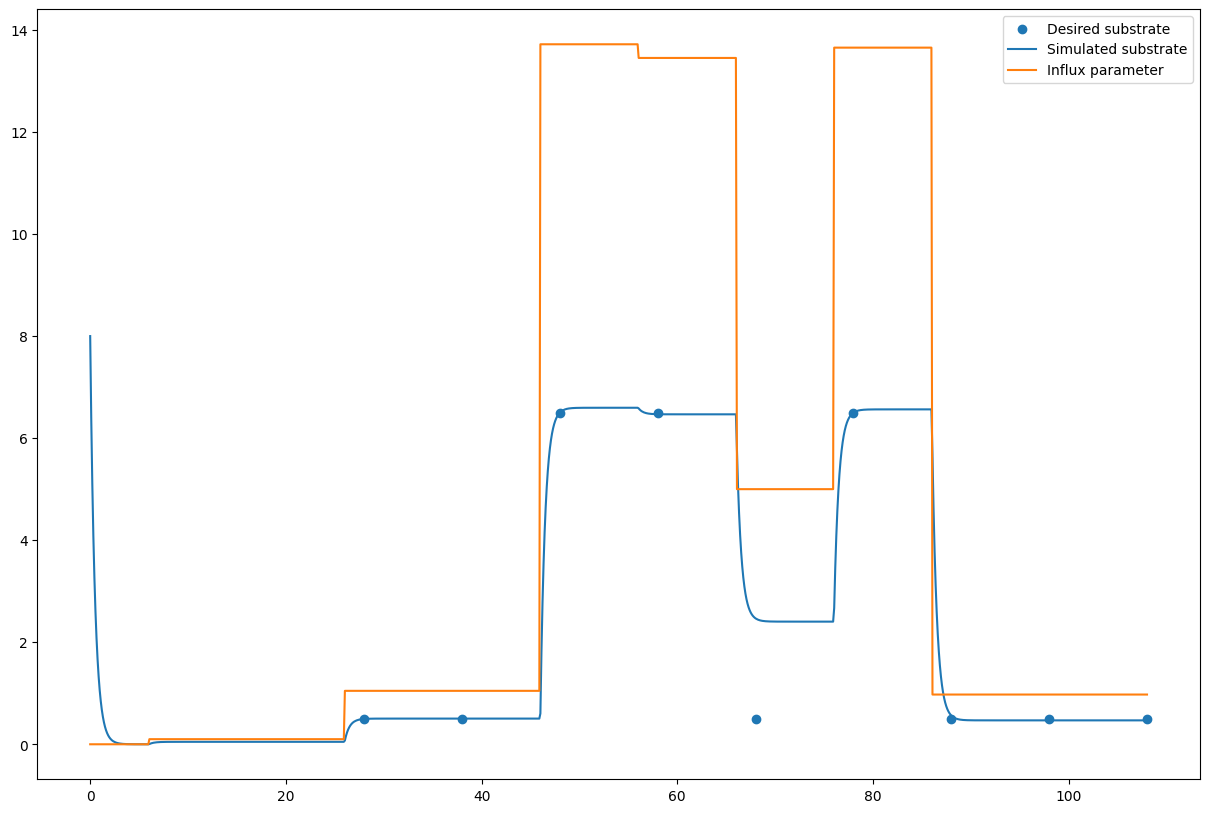

In [19]:
plot_solution(pypesto_problem=pypesto_problem, pypesto_result=pypesto_result, petab_problem=petab_problem, controlled=True)

<Axes: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=-9.209e+00)'>

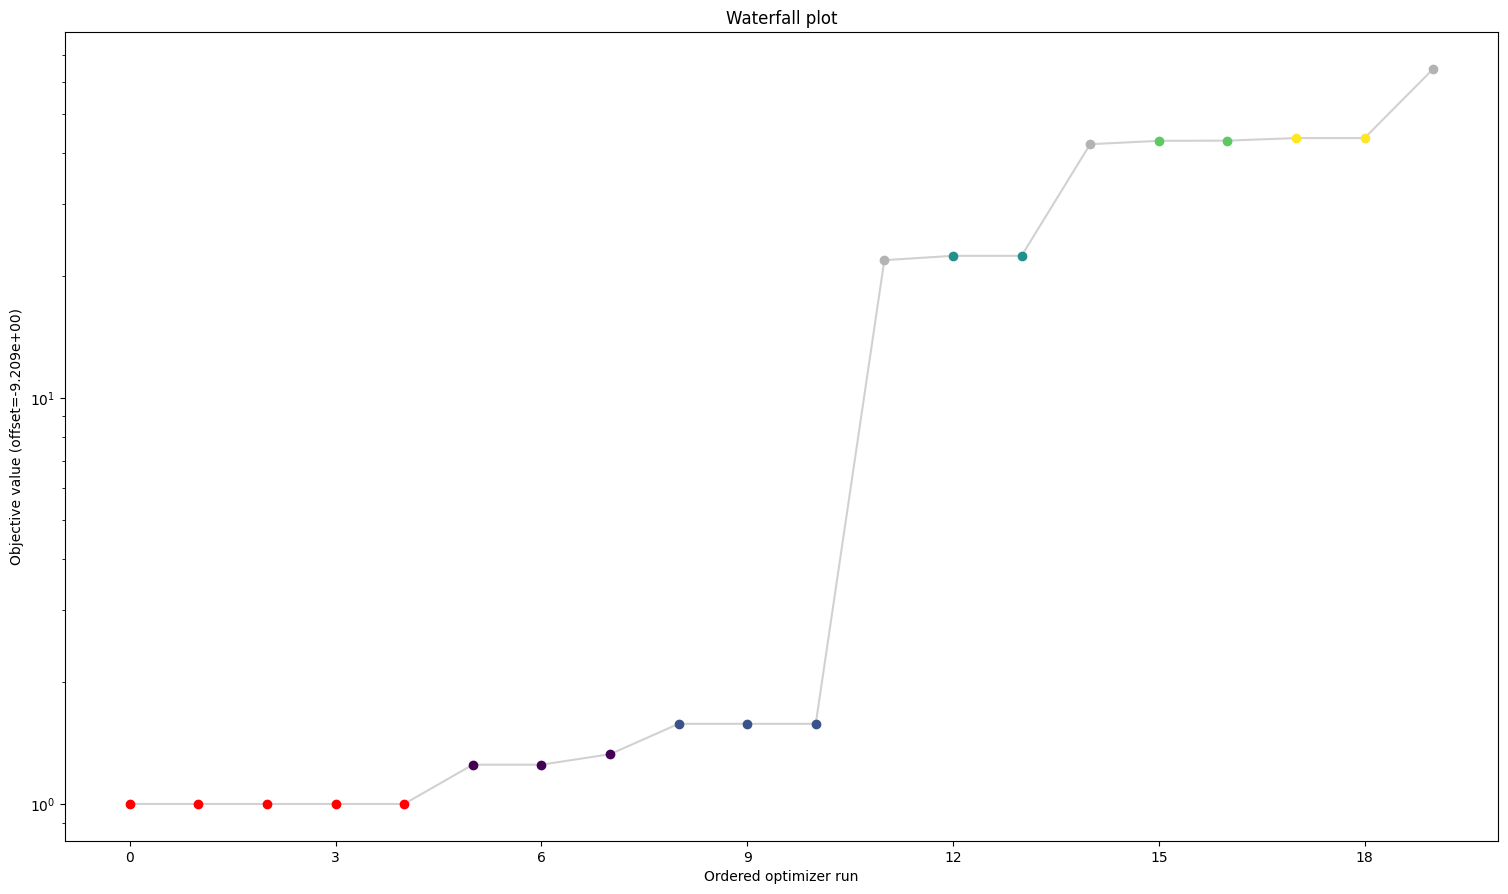

In [20]:
pypesto.visualize.waterfall(pypesto_result)

<Axes: title={'center': 'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

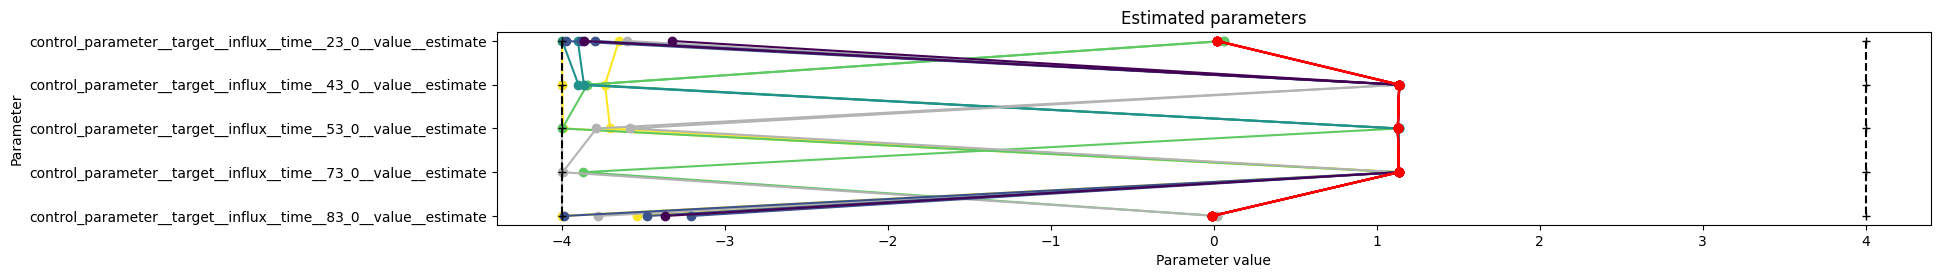

In [21]:
pypesto.visualize.parameters(pypesto_result)

In [22]:
petab_problem.unscale_parameters(dict(zip(pypesto_problem.x_names, pypesto_result.optimize_result.list[0].x)))

{'control_parameter__target__influx__time__3_0__value__0_1': 0.1,
 'control_parameter__target__influx__time__23_0__value__estimate': 1.0473716682799006,
 'control_parameter__target__influx__time__43_0__value__estimate': 13.719371787650756,
 'control_parameter__target__influx__time__53_0__value__estimate': 13.451558464127169,
 'control_parameter__target__influx__time__73_0__value__estimate': 13.653535255595065,
 'control_parameter__target__influx__time__63_0__value__5_0': 5.000000000000001,
 'control_parameter__target__influx__time__83_0__value__estimate': 0.9747863266419423,
 'decay': 2.0800924725290755,
 'substrate0': 8.00005505072207}